In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm

from kooplearn.datasets.stochastic import LangevinTripleWell1D
class LangevinTripleWell1D(DiscreteTimeDynamics):
    def __init__(
        self,
        gamma: float = 0.1,
        kt: float = 1.0,
        dt: float = 1e-4,
        rng_seed: Optional[int] = None,
        height=0.1,
        sigma=0.05,
        freq=500
    ):
        self.gamma = gamma
        self.kt = kt
        self.rng = np.random.default_rng(rng_seed)
        self.dt = dt

        self._inv_gamma = (self.gamma) ** -1
        self.list_centers = []
        self.height = height
        self.sigma = sigma
        self.freq = freq
    def sample(self, X0: np.ndarray, T: int = 1, show_progress: bool = False):
        X0 = np.asarray(X0)
        if X0.ndim == 0:
            X0 = X0[None]

        memory = np.zeros((T + 1,) + X0.shape)
        meta_forces = np.zeros((T + 1,) + X0.shape)
        forces = np.zeros((T + 1,) + X0.shape)
        memory[0] = X0
        show_progress = True
        if show_progress:
            _iter = tqdm.tqdm(range(T), desc="Generating data", unit="step", leave=False)
        else:
            _iter = range(T)

        for t in _iter:
            if t% self.freq ==0 and t !=0:
                self.list_centers.append(memory[t])
            memory[t + 1], forces[t+1], meta_forces[t + 1] = self._step(memory[t])
        return memory, forces, meta_forces
    def eig(self):
        if not hasattr(self, "_ref_evd"):
            self._compute_ref_evd()
        return self._ref_evd
    def _compute_ref_evd(self):
        assets_path = Path(__file__).parent / "assets"

        lap_x = scipy.sparse.load_npz(assets_path / "1D_triple_well_lap_x.npz")
        grad_x = scipy.sparse.load_npz(assets_path / "1D_triple_well_grad_x.npz")
        cc = np.load(assets_path / "1D_triple_well_cc.npz")

        force = scipy.sparse.diags(self.force_fn(cc))

        # Eq.(31) of https://doi.org/10.1007/978-3-642-56589-2_9 recalling that \sigma^2/(\gamma*2) = kBT
        generator = self._inv_gamma * self.kt * lap_x + self._inv_gamma * force.dot(
            grad_x
        )
        generator = generator * self.dt

        vals, vecs = np.linalg.eig(generator.toarray())

        # Filter out timescales smaller than dt
        mask = np.abs(vals.real) < 1.0
        vals = vals[mask]
        vecs = vecs[:, mask]

        vals = np.exp(vals)
        # Checking that the eigenvalues are real
        type_ = vals.dtype.type
        f = np.finfo(type_).eps

        tol = f * 1000
        if not np.all(np.abs(vals.imag) < tol):
            raise ValueError(
                "The computed eigenvalues are not real, try to decrease dt"
            )
        else:
            vals = vals.real

        _k = len(vals)
        evd_sorting_perm = topk(vals, _k)
        vals = evd_sorting_perm.values
        vecs = vecs[:, evd_sorting_perm.indices].real

        dx = cc[1] - cc[0]
        boltzmann_pdf = (dx**-1) * scipy.special.softmax(self.force_fn(cc) / self.kt)
        abs2_eigfun = (np.abs(vecs) ** 2).T
        eigfuns_norms = np.sqrt(romb(boltzmann_pdf * abs2_eigfun, dx=dx, axis=-1))
        vecs = vecs * (eigfuns_norms**-1.0)

        # Storing the results
        self._ref_evd = LinalgDecomposition(vals, cc, vecs)
        self._ref_boltzmann_density = boltzmann_pdf

    def _step(self, X: np.ndarray):
        F, bias = self.force_fn(X)
        xi = self.rng.standard_normal(X.shape)
        dX = (
            F * self._inv_gamma * self.dt
            + np.sqrt(2.0 * self.kt * self.dt * self._inv_gamma) * xi
        )
        return X + dX, F, bias
    def meta_force(self,x):
        return  ((x - np.array(self.list_centers)) * self.height * np.exp( - ( x - np.array(self.list_centers))**2 / (2 * self.sigma **2))).sum() / (self.sigma**2)
    def force_fn(self, x: np.ndarray):
        bias = 0
        #f_four =  -20*x*(x**2-1) 
        f_four = -4.0 * (
            - 160 *  1.5 * np.exp(-80 * (x**2)) * x
            + 8 * (x**7)
        )
        f_two =-4.0 * (
            - 160 * 0.5* np.exp(-80 * (x**2)) * x
            + 8 * (x**7)
        ) #  -5
        return f_two, f_two-f_four #-8*(x-1)*(x+1)**2 - 8*(x-1)**2*(x+1)


In [3]:
langevin = LangevinTripleWell1D(rng_seed=0,gamma=2.0,dt=1e-4,height=0.05,sigma=0.1,freq=2000,kt=1.0) #sigma=0.1

In [4]:
sample, forces, meta_forces = langevin.sample(0.0,2_000_000)
#sample = np.load("sample_bias.np",allow_pickle=True)
#forces = np.load("forces_bias.np",allow_pickle=True)
#meta_forces = np.load("meta_forces.np",allow_pickle=True)
#sample.shape

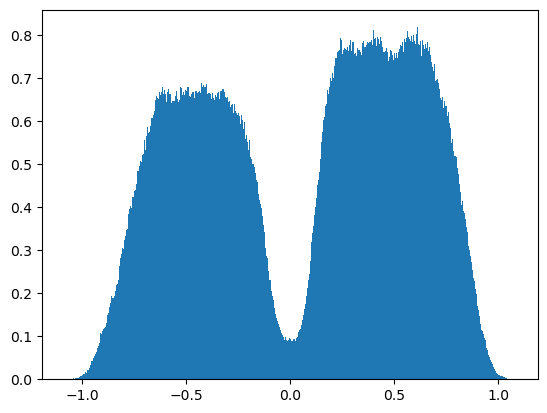

In [5]:
import matplotlib.pyplot as plt
plt.hist(sample, bins=500, density=True);

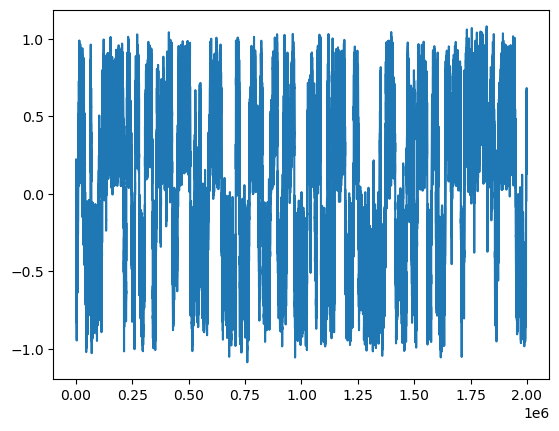

In [6]:
plt.plot(sample)


In [122]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
from kooplearn.models import kernel_generator
#0.2 1e-2 1000 PCR
kernel = RBF(length_scale=np.array([0.08]))#0.11 #0.345 works  well #0.4 best
#model = kooplearn.models.kernel.KernelGenerator(kernel, reduced_rank=False, rank=6
#                            
#                                   , tikhonov_reg=1e-4
#          
#                         )
eta=1e-3
eta1=3e-2
model = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel, reduced_rank=False, eta=eta, rank=6#3e-2
                                   
                                   , tikhonov_reg=2.5e-1 #4e-1
                        )
model_weights = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel, reduced_rank=False, eta=eta1, rank=10#3e-2
                                   
                                   , tikhonov_reg=4e-1 #4e-1
                        )                           
model_thermo_correction = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel, reduced_rank=False, eta=4e-4, rank=10
                                
                                   , tikhonov_reg=1e-4
                                   )
#model_dyn_correction = kooplearn.models.kernel.KernelGenerator(kernel, reduced_rank=False, rank=6
                                   
#                                   , tikhonov_reg=1e-4
#                                   )

In [123]:

def energy(x):
    return -4 * ( np.exp(-80*x**2))
def zero_bias(x):
    return 0.0
test=sample[:2_000_000:500]
train_data = traj_to_contexts(test)
forces_train = traj_to_contexts(forces[:2_000_000:500])
train_data.shape
bias = traj_to_contexts(meta_forces[:2_000_000:500])
weights = np.exp(energy(sample))
context_weights = traj_to_contexts(weights[:2_000_000:500])

In [124]:
model = model.fit(train_data,forces=(forces_train-bias)/2.0,friction=np.array([2*1.0/2.0]),weights=None) #np.sqrt(2))
model_weights = model_weights.fit(train_data,forces=(forces_train-bias)/2.0,friction=[2*1.0/2.0],weights=context_weights) #np.sqrt(2))

model_thermo_correction = model_thermo_correction.fit(train_data,forces=(forces_train)/2.0,friction=np.array([2*1.0/2.0]),weights=None) #np.sqrt(2))
#model_dyn_correction = model_dyn_correction.fit(train_data,forces=(forces_train-bias)/2.0,friction=2*1.0/2.0,bias=None) #np.sqrt(2))

Fitted KernelInverseGenerator model. Lookback length set to 1
Fitted KernelInverseGenerator model. Lookback length set to 1
Fitted KernelInverseGenerator model. Lookback length set to 1


In [125]:
vals_gen,vecs_gen = model.eig(eval_right_on=train_data[:,:1, ...])
vecs_gen[:,-2] = (vecs_gen[:,-2] )/( vecs_gen[:,-1])
#vals_gen_no,vecs_gen_no = model_no_correction.eig(eval_right_on=train_data[:,:1, ...])

vals_gen_w,vecs_gen_w = model_weights.eig(eval_right_on=train_data[:,:1, ...])
vecs_gen_w[:,-2] = (vecs_gen_w[:,-2] )/( vecs_gen_w[:,-1])
vals_gen_thermo,vecs_gen_thermo = model_thermo_correction.eig(eval_right_on=train_data[:,:1, ...])
vecs_gen_thermo[:,-2] /= vecs_gen_thermo[:,-1]
#vals_gen_dyn,vecs_gen_dyn = model_dyn_correction.eig(eval_right_on=train_data[:,:1, ...])


In [126]:
print((eta-1/vals_gen)[-10:])
print((eta1-1/vals_gen_w)[-10:])
#print(vals_gen_no)
print(4e-4-1/vals_gen_thermo)
#print(vals_gen_dyn)

[-1.61076440e+01+0.j -1.55461035e+01+0.j -5.27951990e+00+0.j
 -4.82184265e+00+0.j -4.20069294e-02+0.j -8.78567726e-03+0.j]
[-69.01103085+0.j -66.12889381+0.j -44.81444973+0.j -43.67180402+0.j
 -20.42967254+0.j -20.25193978+0.j  -6.53264981+0.j  -6.41974396+0.j
  -0.21386184+0.j  -0.15776371+0.j]
[-7.34638601e+00+0.j -6.45298347e+00+0.j -5.96913653e+00+0.j
 -5.59684851e+00+0.j -3.16789829e+00+0.j -2.59782670e+00+0.j
 -1.28036460e+00+0.j -9.19171985e-01+0.j -1.06276635e-01+0.j
 -4.15435424e-04+0.j]


###### 

(array([], dtype=int64),)


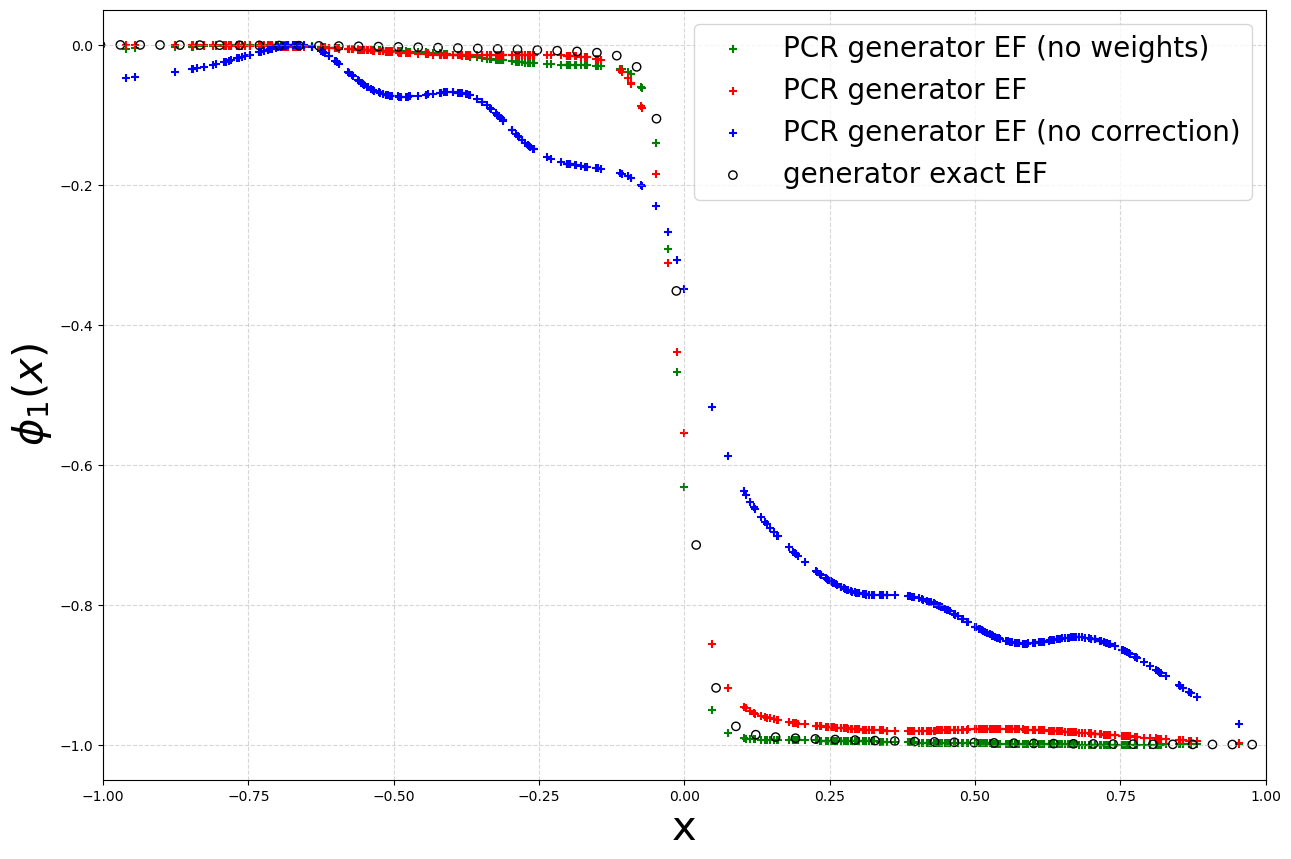

In [140]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt




solutions4 =np.load("/home/tdevergne@iit.local/Documents/eigenfunctions_simple1.np",allow_pickle=True)
x_values4  =np.load("/home/tdevergne@iit.local/Documents/centers_simple1.np",allow_pickle=True)
solutions2 =np.load("/home/tdevergne@iit.local/Documents/eigenfunctions_simple2.np",allow_pickle=True)
x_values2  =np.load("/home/tdevergne@iit.local/Documents/centers_simple2.np",allow_pickle=True)

#plt.scatter(np.squeeze(train_data[:,:1, ...]), vecs_gen[:,-2]/vecs_gen[:,-1],label="PCR transfer first eigenfunction")
#plt.plot(decomp.x[values],-funcs[values,2],label="exact eigenfunction",color="r")
num = 3
plt.figure(figsize=(15,10))
#values = np.where(np.logical_and(decomp.x>-1,decomp.x<1))[0]
print(np.where(vecs_gen[:,-1]==0))

new_0 = -(vecs_gen[:,-1]-vecs_gen[:,-1].min())/(vecs_gen[:,-1].min()-vecs_gen[:,-1].max())


    #vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    #vecs_gen[:,-i-1] /= vecs_gen[:,-1]
new_gen = (vecs_gen[:,-2]-vecs_gen[:,-2].min())/(vecs_gen[:,-2].min()-vecs_gen[:,-2].max())
new_gen_w =  (vecs_gen_w[:,-2]-vecs_gen_w[:,-2].min())/(vecs_gen_w[:,-2].min()-vecs_gen_w[:,-2].max())
new_gen_no = (vecs_gen_thermo[:,-2]-vecs_gen_thermo[:,-2].min())/(vecs_gen_thermo[:,-2].min()-vecs_gen_thermo[:,-2].max())
new_sol4 = (solutions4[:,1]-solutions4[:,1].min())/(solutions4[:,1].min()-solutions4[:,1].max())

plt.scatter(np.squeeze(train_data[::10,:1, ...]),new_gen_w[::10], marker="+", color='g',label="PCR generator EF (no weights)")
plt.scatter(np.squeeze(train_data[::10,:1, ...]),-1-new_gen[::10], marker="+", color='r',label="PCR generator EF")
plt.scatter(np.squeeze(train_data[::10,:1, ...]), -1-new_gen_no[::10], marker="+", color='b',label="PCR generator EF (no correction)")
plt.scatter(x_values4[::10],new_sol4[::10], marker="o", color='k', label="generator exact EF",facecolors='none')
#plt.plot(x_values2,new_sol2,  color='g', label="generator exact EF $V_{eff}$")
plt.grid(True, linestyle='--', alpha=.5)
plt.xlim(-1, 1)
    #axes[i//num, i%num].set_ylim(y_min, y_max)


plt.xlabel('x', fontsize=30)
plt.ylabel(r'$\phi_1(x)$', fontsize=30)
plt.legend(fontsize=20)
plt.show()

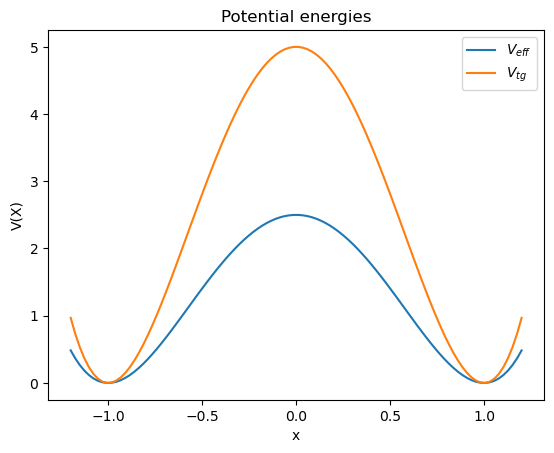

In [128]:
def potential(x,strength):
    """
    See Example 1 of "Modeling Molecular Kinetics with tICA and the Kernel Trick" 10.1021/ct5007357
    """
    return strength * x**2 * (0.5 *x**2 -1)

x = np.linspace(-1.2,1.2,100)

plt.plot(x,potential(x,strength=5)- potential(1,strength=5),label=r"$V_{eff}$")
plt.plot(x,potential(x,strength=10)-potential(-1,strength=10), label="$V_{tg}$")
plt.xlabel("x")
plt.ylabel("V(X)")
plt.title("Potential energies")
plt.legend()

In [129]:
model.kernel_X

array([[1.00000000e+00, 4.50646322e-01, 5.89878938e-01, ...,
        2.72319489e-09, 8.96886096e-08, 8.60317922e-09],
       [4.50646322e-01, 1.00000000e+00, 7.26445500e-02, ...,
        3.40936472e-06, 5.37476132e-05, 8.51745644e-06],
       [5.89878938e-01, 7.26445500e-02, 1.00000000e+00, ...,
        2.53171992e-12, 1.51865236e-10, 9.68176755e-12],
       ...,
       [2.72319489e-09, 3.40936472e-06, 2.53171992e-12, ...,
        1.00000000e+00, 8.43449722e-01, 9.82866433e-01],
       [8.96886096e-08, 5.37476132e-05, 1.51865236e-10, ...,
        8.43449722e-01, 1.00000000e+00, 9.23993644e-01],
       [8.60317922e-09, 8.51745644e-06, 9.68176755e-12, ...,
        9.82866433e-01, 9.23993644e-01, 1.00000000e+00]])

In [130]:
kernel(test)

array([[1.00000000e+00, 4.50646322e-01, 5.89878938e-01, ...,
        8.96886096e-08, 8.60317922e-09, 4.20286018e-03],
       [4.50646322e-01, 1.00000000e+00, 7.26445500e-02, ...,
        5.37476132e-05, 8.51745644e-06, 1.23416950e-01],
       [5.89878938e-01, 7.26445500e-02, 1.00000000e+00, ...,
        1.51865236e-10, 9.68176755e-12, 8.28199223e-05],
       ...,
       [8.96886096e-08, 5.37476132e-05, 1.51865236e-10, ...,
        1.00000000e+00, 9.23993644e-01, 5.76799526e-02],
       [8.60317922e-09, 8.51745644e-06, 9.68176755e-12, ...,
        9.23993644e-01, 1.00000000e+00, 2.06163722e-02],
       [4.20286018e-03, 1.23416950e-01, 8.28199223e-05, ...,
        5.76799526e-02, 2.06163722e-02, 1.00000000e+00]])

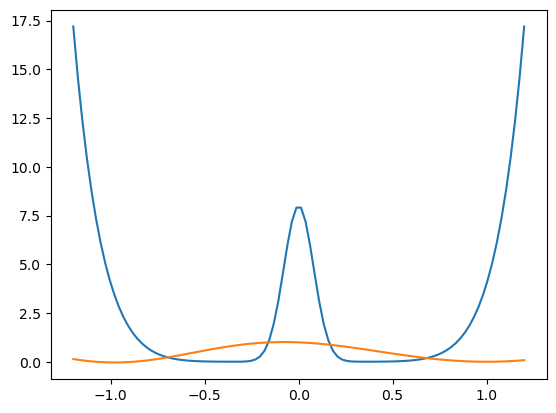

In [131]:
plt.plot(x,4*(x**8+ 2*np.exp(-80*(x**2)) ))
plt.plot(x,-2*np.exp(-(x-1)**2)-2*np.exp(-(x+1)**2/0.5)+2)


In [132]:
sample_bias = np.column_stack((sample,energy(sample)))
np.savetxt("2D_pot_bias.dat2",sample_bias)
